In [79]:
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from gensim.models import FastText
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from pyarabic.araby import strip_tashkeel, normalize_alef, normalize_teh, tokenize
import tnkeeh
import random
import ipywidgets as widgets
from gensim.models import FastText
from nltk import pos_tag, word_tokenize
from xgboost import XGBClassifier
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional


In [80]:
# # Normalization: remove diacritics from the text & Punctuation mark removal & Numbers & Non-arabic & alef, teh 
# def normalization(text):

#     # Remove non-Arabic characters, punctuation, and numbers
#     text = re.sub(r'[^\u0621-\u064A\s]', '', text)
    
#     # Remove diacritics
#     text = strip_tashkeel(text)
    
#     # Normalize Alef and Teh characters
#     text = normalize_alef(text)
#     text = normalize_teh(text)
    
#     # Define character mapper
#     char_mapper = {
#         'ک': 'ك',
#         'ﺑ': 'ب',
#         'ھ': 'ه',  # Mapping 'ھ' to 'ه'
#         'ی': 'ى'
#     }

#     # Map characters using char_mapper
#     for src_char, target_char in char_mapper.items():
#         text = text.replace(src_char, target_char)
    
#     # Further cleaning using tnkeeh
#     tnkeeh_obj = tnkeeh.Tnkeeh(
#         remove_special_chars=True,
#         remove_english=True,
#         normalize=True,
#         remove_diacritics=True,
#         remove_tatweel=True,
#         remove_html_elements=True,
#         remove_links=True,
    #     remove_twitter_meta=True
    # )
    # text = tnkeeh_obj.clean_raw_text(text)[0]
    
    # return text

def normalization(text):
    text = re.sub(r'[^\u0621-\u064A\s]', '', text)  # Remove non-Arabic characters
    text = strip_tashkeel(text)  # Remove diacritics
    text = normalize_alef(text)  # Normalize Alef characters
    text = normalize_teh(text)  # Normalize Teh characters

    # Additional normalization using tnkeeh library
    tnkeeh_obj = tnkeeh.Tnkeeh(
        remove_special_chars=True,
        remove_english=True,
        normalize=True,
        remove_diacritics=True,
        remove_tatweel=True,
        remove_html_elements=True,
        remove_links=True,
        remove_twitter_meta=True
    )
    text = tnkeeh_obj.clean_raw_text(text)[0]
    return text
# Test the normalization function
text = "وَإنّي لمُشْتاقٌه إلى ظِلّ صاحِبٍ،"
normalized_text = normalization(text)
print(normalized_text)


واني لمشتاقه الا ظل صاحب


In [81]:
# stemming
def stemming(word):
    
    # Create an instance of the ISRI Arabic Stemmer

    stemmer = ISRIStemmer()
    return stemmer.stem(word)

text = 'لمشتاق'
result = stemming(text)
print(result)

شتق


In [82]:
# tokenization
def tokenization(text):
    
    
    text = tokenize(text)
    return text

text = 'يروق ويصفو ان كدرت عليه '

result = tokenization(text)
print(result)

['يروق', 'ويصفو', 'ان', 'كدرت', 'عليه']


In [83]:

stop_words_file_name = 'stopWords.txt'
stop_words = []
with open(stop_words_file_name, encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        stop_words.append(line)

stop_words = list(set(stop_words))
stop_words += stopwords.words('arabic')

print(stop_words)

['', 'ثم', 'واضاف', 'أيضا', 'ماانفك', 'هللة', 'ضد', 'وراءَك', 'أبٌ', 'خمس', 'جدا', 'مرّة', 'لوكالة', 'أنفسنا', 'عاما', 'حاليا', 'اليها', 'نفسك', 'غالبا', 'أفعل به', 'او', 'بسبب', 'بها', 'خلافا', 'تينك', 'الذي', 'اول', 'خمسمئة', 'تاسع', 'ثمانين', 'إلي', 'أنفسهم', 'وأن', 'والتي', 'أولالك', 'اثنان', 'في', 'تسعمئة', 'إياهم', 'أمامكَ', 'حَذارِ', 'االتى', 'ين', 'طالما', 'وما', 'أصلا', 'تلقاء', 'قاطبة', 'أجل', 'قلما', 'ثلاث', 'التى', 'عشر', 'تسع', 'لو', 'مع', 'رويدك', 'تِه', 'لن', 'علم', 'مقابل', 'اف', 'وإن', 'لازال', 'ايام', 'الألاء', 'سادس', 'الماضي', 'خمسين', 'تانِ', 'عشرة', 'ثلاثاء', 'ثمنمئة', 'أمام', 'لكنه', 'بغتة', 'أما', 'تسعون', 'عجبا', 'واكد', 'معاذ', 'فى', 'أبدا', 'كاف', 'وقف', 'سرعان', 'فكان', 'تخذ', 'قطّ', 'شمال', 'اخرى', 'عندما', 'ستون', 'ثمّ', 'اثنين', 'قرش', 'فوق', 'لكن', 'ي', 'حاء', 'منذ', 'أولاء', 'صهْ', 'نفسه', 'خال', 'مكانكنّ', 'دواليك', 'قليل', 'فهي', 'حين', 'تسعين', 'يمين', 'شَتَّانَ', 'دينار', 'جنيه', 'ولكن', 'ا?', 'بات', 'شخصا', 'ورد', 'طاء', 'أكتوبر', 'بين', 'تارة', 'و

In [84]:
def remove_stop_words(words, stop_words=stop_words):
    
    result = [] 
    removed_indexes = []
    for i in range(len(words)):
        if words[i] in stop_words:
            removed_indexes.append(i)
        else:
            result.append(words[i])
        
    removed_indexes.sort(reverse=True) # for save remove of pos tagging 
    return result, removed_indexes

remove_stop_words(['يروق', 'ويصفو', 'ان', 'كدرت', 'عليه'])


(['يروق', 'ويصفو', 'كدرت'], [4, 2])

In [85]:

# Function to extract meter patterns from poem lines
def extract_meter_patterns(poem_lines):
    meter_patterns = []
    for line in poem_lines:
        pattern = re.sub(r'[^\u0621-\u064A]', '', line)  # Remove non-Arabic characters
        pattern = re.sub(r'[ا]', 'A', pattern)  # Replace Alef with 'A'
        pattern = re.sub(r'[و]', 'W', pattern)  # Replace Waw with 'W'
        pattern = re.sub(r'[ي]', 'Y', pattern)  # Replace Ya with 'Y'
        pattern = re.sub(r'[ه]', 'H', pattern)  # Replace Ha with 'H'
        pattern = re.sub(r'[م]', 'M', pattern)  # Replace Mim with 'M'
        meter_patterns.append(pattern)
    return meter_patterns


In [86]:
# Example poem lines (replace with your actual data)
poem_lines = [
    "مرحبا بالعالم!",
    "أهلا وسهلا بكم",
    "يا ذا الطلعة البهية",
    "هذه هي الأبيات الأربع"
]

# Call the function to extract meter patterns
meter_patterns = extract_meter_patterns(poem_lines)

# Print or inspect the meter patterns
for pattern in meter_patterns:
    print(pattern)


MرحبAبAلعAلM
أHلAWسHلAبكM
YAذAAلطلعةAلبHYة
HذHHYAلأبYAتAلأربع


In [87]:
def detect_rhyme_scheme(poem_lines):
    rhyme_dict = {}
    rhyme_pattern = []

    for line in poem_lines:
        line = normalization(line)
        segments = tokenization(line)
        words, _ = remove_stop_words(segments)
        number_of_words = len(words)
        for i in range(number_of_words):
            words[i] = stemming(words[i])
        
        # Regular expression to detect end rhymes (last word of each line)
        rhyme_regex = re.compile(r'\b(\w+)\b')
        words = rhyme_regex.findall(' '.join(words))
        if words:
            last_word = words[-1]
            if last_word in rhyme_dict:
                rhyme_pattern.append(rhyme_dict[last_word])
            else:
                rhyme_dict[last_word] = chr(65 + len(rhyme_dict))  # Assign a unique character to each rhyme
                rhyme_pattern.append(rhyme_dict[last_word])
        else:
            rhyme_pattern.append('')  # Append empty string if no words found

    return ''.join(rhyme_pattern)

# Example usage:
poem_lines = [
    " بني الحبُّ على الجورِ فلو",
    " أنصَفَ المعشوقُ فيهِ لَسَمَجْ ",
    "ليسَ يستحسنُ في وصفِ الهوى"
]

rhyme_pattern = detect_rhyme_scheme(poem_lines)
print(f"Rhyme Patterns: {rhyme_pattern}")

Rhyme Patterns: ABC


In [88]:
# Function to convert patterns to vectors
def convert_to_vector(patterns, length=100):
    vectors = []
    for pattern in patterns:
        vector = [0] * length
        for char in pattern:
            if isinstance(char, str) and len(char) == 1:  # Ensure char is a single character
                index = ord(char) % length
                vector[index] += 1
        vectors.append(vector)
    return vectors

vectors = convert_to_vector(rhyme_pattern)

for pattern, vector in zip(rhyme_pattern, vectors):
    print(f"Pattern: {pattern} -> Vector: {vector}")

print('\n')
vectors = convert_to_vector(meter_patterns)

for pattern, vector in zip(meter_patterns, vectors):
    print(f"Pattern: {pattern} -> Vector: {vector}")


Pattern: A -> Vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pattern: B -> Vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Pattern: C -> Vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Pattern: MرحبAبAلعAلM -> Vect

In [89]:
# Function for preprocessing text (including meter extraction and rhyme detection)

# Function to preprocess text and extract features
def preprocessing(text):
    normalized_text = normalization(text)
    segments = tokenization(normalized_text)
    words, _ = remove_stop_words(segments)
    if not words:
        return [], [], [], []

    # POS tagging using NLTK
    pos_tags = pos_tag(word_tokenize(normalized_text))

    # Extract POS tags and create a feature vector
    pos_features = [tag for _, tag in pos_tags]

    stemmed_words = [stemming(word) for word in words]
    meter_patterns = extract_meter_patterns([normalized_text])
    rhyme_pattern = detect_rhyme_scheme([normalized_text])

    # Convert meter patterns and rhyme schemes to vectors
    meter_vector = convert_to_vector(meter_patterns)
    rhyme_vector = convert_to_vector(rhyme_pattern)

    return stemmed_words, meter_vector, rhyme_vector, pos_features

text = "أينَ منْ كانَ قبلنَا أين أينَا"

result = preprocessing(text)
print(result)
print('\n')
for word in result:
    print('\n')
    print(word)


(['اين', 'قبل', 'اين', 'اين'], [[0, 0, 1, 1, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], ['JJ', 'NNP', 'NNP', 'NNP', 'NNP', 'NN'])




['اين', 'قبل', 'اين', 'اين']


[[0, 0, 1, 1, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 

exchange the english names with arabic ones

In [90]:
# Function to load data and normalize text
# def load_data(dataset_path):
#     data = []
#     labels = []
#     authors = []  # List to store author names
#     poem_authors = []  # List to store the author of each poem
    
#     for author in os.listdir(dataset_path):
#         author_folder = os.path.join(dataset_path, author)
#         if os.path.isdir(author_folder):
#             authors.append(author)  # Add author to the list
#             for poem in os.listdir(author_folder):
#                 poem_path = os.path.join(author_folder, poem)
#                 if poem_path.endswith('.txt'):
#                     with open(poem_path, 'r', encoding='utf-8') as file:
#                         text = file.read()
#                         preprocessed_text = preprocessing(text)  # Preprocess the poem text
#                         data.append((preprocessed_text, author))  # Store preprocessed text along with author
#                         poem_authors.append(author)  # Store the author of the poem
#                         labels.append(author)  # Store the author (for compatibility, you may remove this line if not needed)
#     return data, labels, authors, poem_authors
def load_data(dataset_path):
    data = []
    labels = []
    authors = []
    poem_authors = []

    for author in os.listdir(dataset_path):
        author_folder = os.path.join(dataset_path, author)
        if os.path.isdir(author_folder):
            authors.append(author)
            for poem in os.listdir(author_folder):
                poem_path = os.path.join(author_folder, poem)
                if poem_path.endswith('.txt'):
                    with open(poem_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                        preprocessed_text = preprocessing(text)
                        data.append((preprocessed_text[0], preprocessed_text[1], preprocessed_text[2], author))
                        poem_authors.append(author)
                        labels.append(author)

    return data, labels, authors, poem_authors

dataset_path = 'dataset'
data, labels, authors, poem_authors = load_data(dataset_path)
# Print the names of the authors
print("Authors:", authors)

# Print the poem data and their corresponding authors
for poem, author in zip(data, poem_authors):
    print("Author:", author)
    print("Poem:", poem)
    print()

Authors: ['AbuAlAtahiya', 'AbuAlFadlAldarimi', 'AbuFirasAlHamdani', 'AbuNuwas', 'AliAlTuhami', 'AliIbnAlJahm', 'AlMutanabbi', 'IbnAlFarid', 'UlayyaBintAlMahdi']
Author: AbuAlAtahiya
Poem: (['وني', 'شتق', 'صحب', '\n', 'يرق', 'صفو', 'كدر', '\n', 'عذر', 'انس', 'جفت'], [[0, 2, 2, 1, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 3, 0, 1, 1, 0, 1, 1, 3, 0, 6, 1, 8, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'AbuAlAtahiya')

Author: AbuAlAtahiya
Poem: (['سكن', 'يبق', 'سكن', '\n', 'يؤذ', 'زمن', '\n', 'دار', 'خبر'], [[0, 1, 1, 2, 2, 

feature extraction

In [91]:
# class TFIDFExtractor:
#     def __init__(self):
#         from sklearn.feature_extraction.text import TfidfVectorizer
#         self.vectorizer = TfidfVectorizer()
#         self.feature_names = None
#         self.author_names = None

#     def fit_transform(self, corpus):
#         # Extract the sentences from the corpus
#         sentences = [sample[0] for sample in corpus]

#         # Extract the authors from the corpus
#         authors = [sample[1] for sample in corpus]

#         # Convert the sentences to strings
#         sentences = [' '.join(sentence) for sentence in sentences]

#         # Fit and transform the sentences
#         tfidf_matrix = self.vectorizer.fit_transform(sentences)

#         # Get the feature names (unique words) as columns
#         self.feature_names = self.vectorizer.get_feature_names_out()

#         # Get the author names as rows
#         self.author_names = authors

#         return tfidf_matrix.toarray()

#     def transform(self, corpus):
#         # Extract the sentences from the corpus
#         sentences = [sample[0] for sample in corpus]

#         # Convert the sentences to strings
#         sentences = [' '.join(sentence) for sentence in sentences]

#         # Transform the sentences
#         tfidf_matrix = self.vectorizer.transform(sentences)

#         return tfidf_matrix.toarray()

#     def get_feature_names(self):
#         return self.feature_names
    
#     def get_author_names(self):
#         return self.author_names

# TF-IDF Extractor class
class TFIDFExtractor:
    def __init__(self):
        self.vectorizer = TfidfVectorizer()

    def fit_transform(self, corpus):
        preprocessed_texts = [' '.join(sample[0]) for sample in corpus]
        authors = [sample[1] for sample in corpus]
        tfidf_matrix = self.vectorizer.fit_transform(preprocessed_texts)
        self.feature_names = self.vectorizer.get_feature_names_out()
        self.author_names = authors
        return tfidf_matrix

    def transform(self, corpus):
        preprocessed_texts = [' '.join(sample[0]) for sample in corpus]
        tfidf_matrix = self.vectorizer.transform(preprocessed_texts)
        return tfidf_matrix

In [43]:
# TF-IDF
# tf_idf = TFIDFExtractor()

In [92]:
# class WordEmbeddingExtractor:
#     def __init__(self, vector_size=100, window=10, min_count=1, workers=4, sg=0):
#         self.vector_size = vector_size
#         self.window = window
#         self.min_count = min_count
#         self.workers = workers
#         self.sg = sg
#         self.model = None
#         self.feature_names = None
#         self.author_names = None

#     def fit_transform(self, corpus):
#         from gensim.models import FastText
#         import numpy as np
#         # Extract the sentences from the corpus
#         sentences = [sample[0] for sample in corpus]

#         # Extract the authors from the corpus
#         authors = [sample[1] for sample in corpus]

#         # Train FastText model
#         self.model = FastText(sentences, vector_size=self.vector_size, window=self.window,
#                               min_count=self.min_count, workers=self.workers, sg=self.sg)

#         # Get the feature names (labeled dimensions) for FastText
#         self.feature_names = [f't{i}' for i in range(self.vector_size)]

#         # Get the author names as rows
#         self.author_names = authors

#         # Create feature vectors for each sentence
#         feature_vectors = []
#         for sentence in sentences:
#             vectors = [self.model.wv[word] for word in sentence if word in self.model.wv]
#             if vectors:
#                 sentence_vector = np.mean(vectors, axis=0)
#             else:
#                 sentence_vector = np.zeros(self.vector_size)
#             feature_vectors.append(sentence_vector)

#         # Convert feature vectors to NumPy array
#         feature_vectors = np.array(feature_vectors)

#         return feature_vectors

#     def transform(self, corpus):
#         import numpy as np
#         # Extract the sentences from the corpus
#         sentences = [sample[0] for sample in corpus]

#         # Create feature vectors for each sentence
#         feature_vectors = []
#         for sentence in sentences:
#             vectors = [self.model.wv[word] for word in sentence if word in self.model.wv]
#             if vectors:
#                 sentence_vector = np.mean(vectors, axis=0)
#             else:
#                 sentence_vector = np.zeros(self.vector_size)
#             feature_vectors.append(sentence_vector)

#         # Convert feature vectors to NumPy array
#         feature_vectors = np.array(feature_vectors)

#         return feature_vectors

#     def get_feature_names(self):
#         return self.feature_names
    
#     def get_author_names(self):
#         return self.author_names
# FastText Extractor class
class WordEmbeddingExtractor:
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4, sg=0):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.sg = sg
        self.model = None

    def fit_transform(self, corpus):
        self.model = FastText(corpus, vector_size=self.vector_size, window=self.window,
                              min_count=self.min_count, workers=self.workers, sg=self.sg)
        embeddings = []
        for text in corpus:
            text_embedding = np.mean([self.model.wv[word] for word in text if word in self.model.wv], axis=0)
            embeddings.append(text_embedding)
        return np.array(embeddings)

    def transform(self, corpus):
        embeddings = []
        for text in corpus:
            text_embedding = np.mean([self.model.wv[word] for word in text if word in self.model.wv], axis=0)
            embeddings.append(text_embedding)
        return np.array(embeddings)


- Double check 

In [45]:
# fast_text = WordEmbeddingExtractor(vector_size=499, window=10, min_count=1, workers=4, sg=0)


we can add Poetic Features they find the rhyme emptional tone and stuff for features extractions and is better done on the original data ( not Preprocess but remove  حركات) - look it up 

combine features

In [103]:

# Function to combine all features into a single feature matrix
def combine_features(tfidf_features, fasttext_features, meter_vectors, rhyme_vectors):
    # Reshape or adjust dimensions if necessary
    tfidf_features = np.atleast_2d(tfidf_features)
    fasttext_features = np.atleast_2d(fasttext_features)
    
    # Flatten meter and rhyme vectors to (samples, features)
    meter_vectors = meter_vectors.reshape(meter_vectors.shape[0], -1)
    rhyme_vectors = rhyme_vectors.reshape(rhyme_vectors.shape[0], -1)
    
    # # Check and print shapes for debugging
    # print(f"TF-IDF Shape: {tfidf_features.shape}")
    # print(f"FastText Shape: {fasttext_features.shape}")
    # print(f"Meter Vectors Shape: {meter_vectors.shape}")
    # print(f"Rhyme Vectors Shape: {rhyme_vectors.shape}")

    # Concatenate features
    combined_features = np.concatenate((tfidf_features, fasttext_features, meter_vectors, rhyme_vectors), axis=1)
    return combined_features


In [94]:

# Function to predict author based on input text
def predict_author(text, tfidf_extractor, fasttext_extractor, classifier):
    preprocessed_text = preprocessing(text)
    tfidf_features = tfidf_extractor.transform([(preprocessed_text[0], '')])
    fasttext_features = fasttext_extractor.transform([preprocessed_text[0]])
    meter_vector = np.array(convert_to_vector(preprocessed_text[1]))
    rhyme_vector = np.array(convert_to_vector(preprocessed_text[2]))
    combined_features = combine_features(tfidf_features.toarray(), fasttext_features, meter_vector, rhyme_vector)
    predicted_author = classifier.predict(combined_features)
    return predicted_author[0]
# def combine_features(tfidf_features, fasttext_features, meter_vectors, rhyme_vectors, pos_features):
#     # Reshape or adjust dimensions if necessary
#     tfidf_features = np.atleast_2d(tfidf_features)
#     fasttext_features = np.atleast_2d(fasttext_features)
    
#     # Flatten meter and rhyme vectors to (samples, features)
#     meter_vectors = meter_vectors.reshape(meter_vectors.shape[0], -1)
#     rhyme_vectors = rhyme_vectors.reshape(rhyme_vectors.shape[0], -1)
#     pos_features = pos_features.reshape(pos_features.shape[0], -1)  # Ensure pos_features is 2D

#     # Check and print shapes for debugging
#     print(f"TF-IDF Shape: {tfidf_features.shape}")
#     print(f"FastText Shape: {fasttext_features.shape}")
#     print(f"Meter Vectors Shape: {meter_vectors.shape}")
#     print(f"Rhyme Vectors Shape: {rhyme_vectors.shape}")
#     print(f"POS Features Shape: {pos_features.shape}")
    
#     # Concatenate features
#     combined_features = np.concatenate((tfidf_features, fasttext_features, meter_vectors, rhyme_vectors, pos_features), axis=1)
#     return combined_features

In [71]:
# Function to plot and print confusion matrix
def plot_confusion_matrix(y_test, y_pred, classes, title='Confusion matrix'):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

Number of training samples: 57
Number of testing samples: 15
Example of the first training sample: (['شتر', 'فؤد', 'انن', '\n', 'ؤرق', 'ذكر', 'حنن', '\n', 'منه', 'زير', 'لاي'], [[0, 1, 1, 2, 6, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 2, 3, 0, 0, 1, 0, 2, 1, 4, 1, 2, 1, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'AliIbnAlJahm')
Example of the second training sample: (['مرض', 'حبب', 'فعد', '\n', 'مرض', 'خوف', '\n', 'فتا', 'حبب', 'يزر'], [[0, 4, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


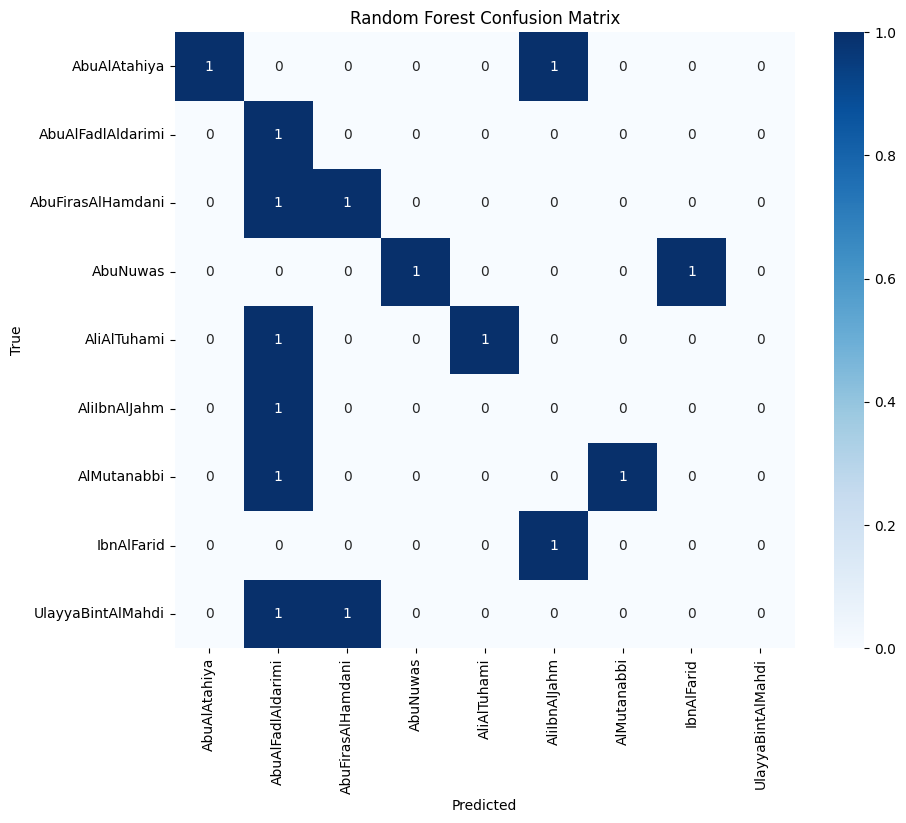

Training SVM...
Classifier: SVM
Accuracy: 0.13333333333333333
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       1.00      0.50      0.67         2
AbuAlFadlAldarimi       0.07      1.00      0.13         1
AbuFirasAlHamdani       0.00      0.00      0.00         2
         AbuNuwas       0.00      0.00      0.00         2
      AlMutanabbi       0.00      0.00      0.00         2
      AliAlTuhami       0.00      0.00      0.00         1
     AliIbnAlJahm       0.00      0.00      0.00         2
       IbnAlFarid       0.00      0.00      0.00         1
UlayyaBintAlMahdi       0.00      0.00      0.00         2

         accuracy                           0.13        15
        macro avg       0.12      0.17      0.09        15
     weighted avg       0.14      0.13      0.10        15




C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


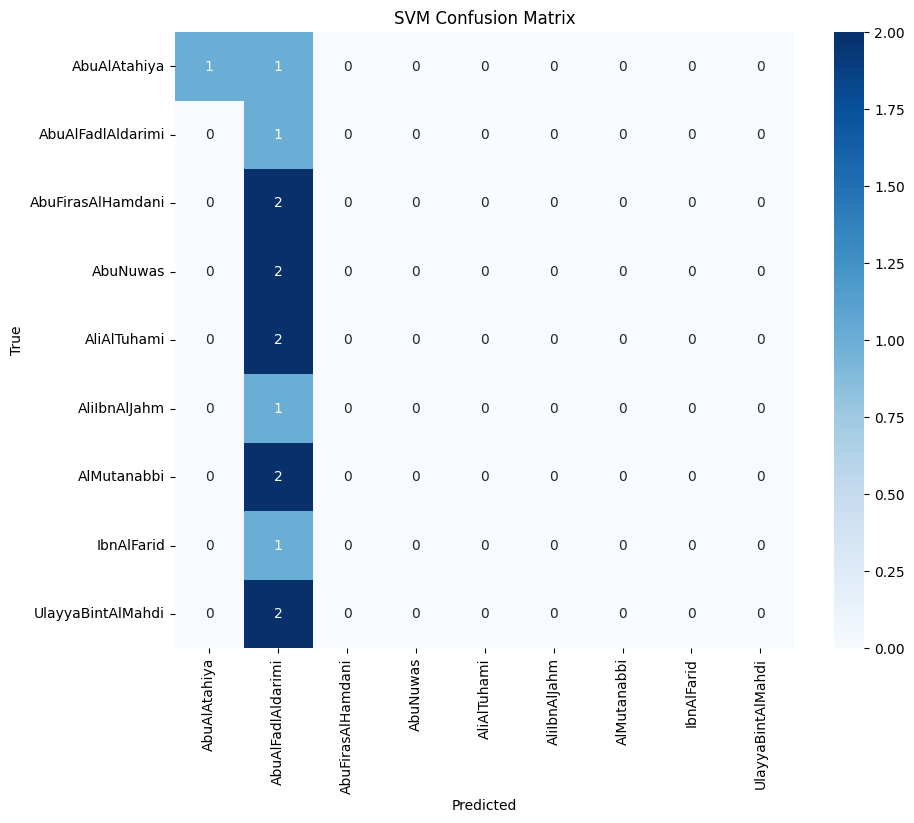

Training K-Nearest Neighbors...
Classifier: K-Nearest Neighbors
Accuracy: 0.06666666666666667
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       1.00      0.50      0.67         2
AbuAlFadlAldarimi       0.00      0.00      0.00         1
AbuFirasAlHamdani       0.00      0.00      0.00         2
         AbuNuwas       0.00      0.00      0.00         2
      AlMutanabbi       0.00      0.00      0.00         2
      AliAlTuhami       0.00      0.00      0.00         1
     AliIbnAlJahm       0.00      0.00      0.00         2
       IbnAlFarid       0.00      0.00      0.00         1
UlayyaBintAlMahdi       0.00      0.00      0.00         2

         accuracy                           0.07        15
        macro avg       0.11      0.06      0.07        15
     weighted avg       0.13      0.07      0.09        15




C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


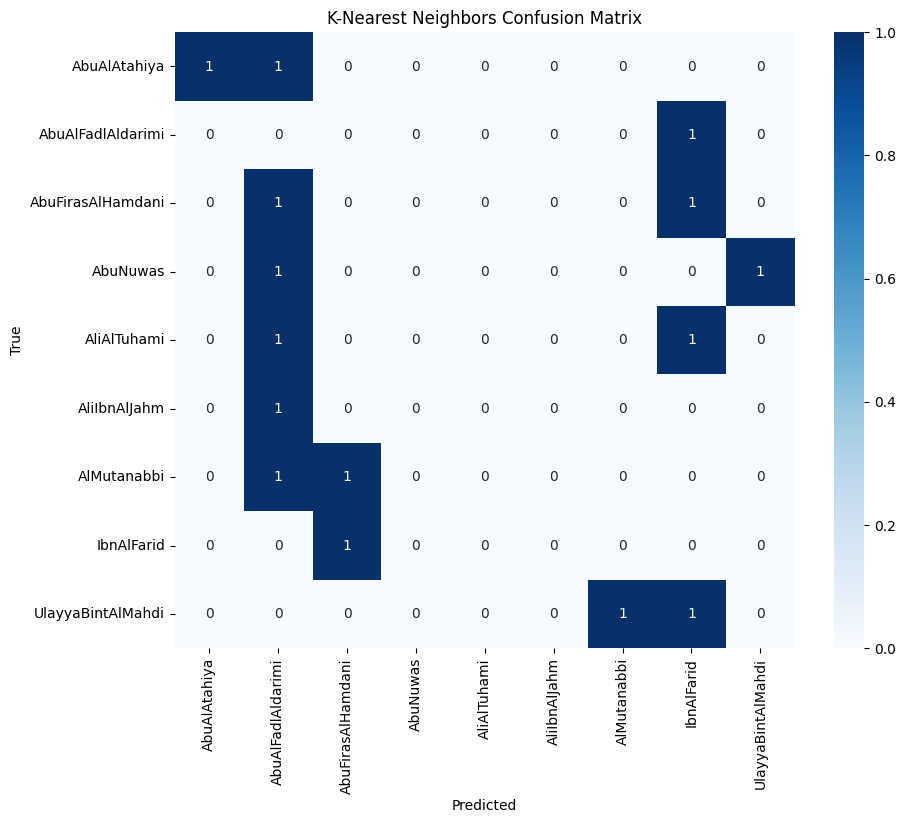

Training MLP...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier: MLP
Accuracy: 0.2
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       0.50      0.50      0.50         2
AbuAlFadlAldarimi       0.00      0.00      0.00         1
AbuFirasAlHamdani       0.25      0.50      0.33         2
         AbuNuwas       0.00      0.00      0.00         2
      AlMutanabbi       0.00      0.00      0.00         2
      AliAlTuhami       1.00      1.00      1.00         1
     AliIbnAlJahm       0.00      0.00      0.00         2
       IbnAlFarid       0.00      0.00      0.00         1
UlayyaBintAlMahdi       0.00      0.00      0.00         2

         accuracy                           0.20        15
        macro avg       0.19      0.22      0.20        15
     weighted avg       0.17      0.20      0.18        15




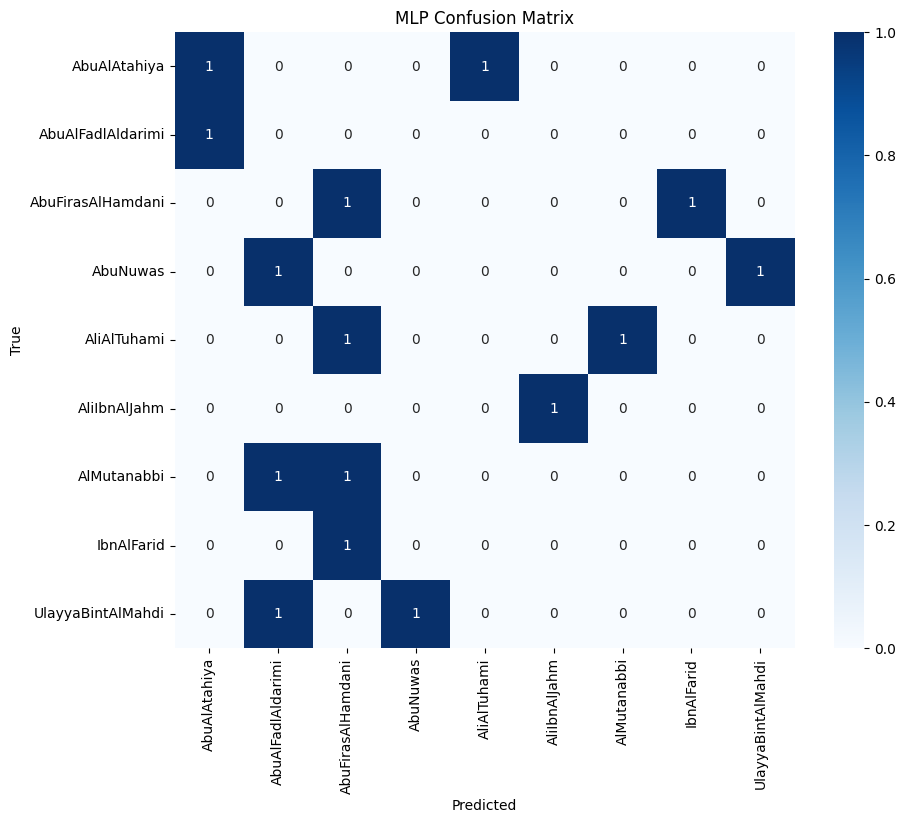

In [49]:
def main():
    dataset_path = 'dataset'  # Specify the path to your dataset
    data, labels, authors, poem_authors = load_data(dataset_path)

    # Split data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of testing samples: {len(test_data)}")

    # Step 1: Extract TF-IDF features
    tf_idf = TFIDFExtractor()
    
    # Debug prints
    print(f"Example of the first training sample: {train_data[0]}")
    print(f"Example of the second training sample: {train_data[1]}")

    # Ensure each sample has at least 4 elements and extract features
    # Handle cases where sample[3] (author label) may be missing
    filtered_train_data = [(sample[0], sample[3]) for sample in train_data if len(sample) > 3]
    tfidf_features = tf_idf.fit_transform(filtered_train_data)

    # Step 2: Extract FastText features
    fast_text_extractor = WordEmbeddingExtractor(vector_size=100)  # Adjust vector_size as needed
    fasttext_features = fast_text_extractor.fit_transform([sample[0] for sample in train_data])

    # Convert test data to feature vectors
    tfidf_features_test = tf_idf.transform([(sample[0], sample[3]) for sample in test_data])
    fasttext_features_test = fast_text_extractor.transform([sample[0] for sample in test_data])

    # Extract meter and rhyme features
    meter_vectors_train = np.array([convert_to_vector(sample[1]) for sample in train_data])
    rhyme_vectors_train = np.array([convert_to_vector(sample[2]) for sample in train_data])
    # pos_features_train = np.array([sample[3] for sample in train_data])  # Assuming POS features are included in data[3]
    # pos_features_test = np.array([sample[3] for sample in test_data])  # Assuming POS features are included in data[3]

    meter_vectors_test = np.array([convert_to_vector(sample[1]) for sample in test_data])
    rhyme_vectors_test = np.array([convert_to_vector(sample[2]) for sample in test_data])

    # Combine all features
    # combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train, pos_features_train)

    # combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test,pos_features_test)

    combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train)

    combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test)

    # Train XGBoost classifier
    # xgb_clf = XGBClassifier()
    # xgb_clf.fit(combined_features_train, train_labels)
    # y_pred = xgb_clf.predict(combined_features_test)


    # # Evaluate performance
    # accuracy = accuracy_score(test_labels, y_pred)
    # report = classification_report(test_labels, y_pred)
    # print(f"XGBoost Classifier Accuracy: {accuracy}")
    # print(f"Classification Report:\n{report}")
    # Train classifiers and evaluate performance
    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "MLP": MLPClassifier()
    }

    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name}...")
        clf.fit(combined_features_train, train_labels)
        y_pred = clf.predict(combined_features_test)

        accuracy = accuracy_score(test_labels, y_pred)
        report = classification_report(test_labels, y_pred)
        print(f"Classifier: {clf_name}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")
        print()

        # Plot confusion matrix
        plot_confusion_matrix(test_labels, y_pred, classes=authors, title=f'{clf_name} Confusion Matrix')

if __name__ == '__main__':
    main()


In [77]:
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from gensim.models import FastText
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from pyarabic.araby import strip_tashkeel, normalize_alef, normalize_teh, tokenize
import tnkeeh
import random
import ipywidgets as widgets

# Normalization function
def normalization(text):
    text = re.sub(r'[^\u0621-\u064A\s]', '', text)  # Remove non-Arabic characters
    text = strip_tashkeel(text)  # Remove diacritics
    text = normalize_alef(text)  # Normalize Alef characters
    text = normalize_teh(text)  # Normalize Teh characters

    # Additional normalization using tnkeeh library
    tnkeeh_obj = tnkeeh.Tnkeeh(
        remove_special_chars=True,
        remove_english=True,
        normalize=True,
        remove_diacritics=True,
        remove_tatweel=True,
        remove_html_elements=True,
        remove_links=True,
        remove_twitter_meta=True
    )
    text = tnkeeh_obj.clean_raw_text(text)[0]
    return text

# Stemming function
def stemming(word):
    stemmer = ISRIStemmer()
    return stemmer.stem(word)

# Tokenization function
def tokenization(text):
    text = tokenize(text)
    return text

# Load stop words
stop_words_file_name = 'stopWords.txt'  # Adjust the filename as per your dataset
stop_words = []
with open(stop_words_file_name, encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        stop_words.append(line)
stop_words = list(set(stop_words))
stop_words += stopwords.words('arabic')

# Function to remove stop words
def remove_stop_words(words, stop_words=stop_words):
    result = []
    removed_indexes = []
    for i in range(len(words)):
        if words[i] in stop_words:
            removed_indexes.append(i)
        else:
            result.append(words[i])
    removed_indexes.sort(reverse=True)  # Reverse sort for safe removal during processing
    return result, removed_indexes

# Function to extract meter patterns from poem lines
def extract_meter_patterns(poem_lines):
    meter_patterns = []
    for line in poem_lines:
        pattern = re.sub(r'[^\u0621-\u064A]', '', line)  # Remove non-Arabic characters
        pattern = re.sub(r'[ا]', 'A', pattern)  # Replace Alef with 'A'
        pattern = re.sub(r'[و]', 'W', pattern)  # Replace Waw with 'W'
        pattern = re.sub(r'[ي]', 'Y', pattern)  # Replace Ya with 'Y'
        pattern = re.sub(r'[ه]', 'H', pattern)  # Replace Ha with 'H'
        pattern = re.sub(r'[م]', 'M', pattern)  # Replace Mim with 'M'
        meter_patterns.append(pattern)
    return meter_patterns

# Function to detect rhyme scheme in a poem
def detect_rhyme_scheme(poem_lines):
    rhyme_dict = {}
    rhyme_pattern = []

    for line in poem_lines:
        line = normalization(line)
        segments = tokenization(line)
        words, _ = remove_stop_words(segments)
        number_of_words = len(words)
        for i in range(number_of_words):
            words[i] = stemming(words[i])

        # Regular expression to detect end rhymes (last word of each line)
        rhyme_regex = re.compile(r'\b(\w+)\b')
        words = rhyme_regex.findall(' '.join(words))
        if words:
            last_word = words[-1]
            if last_word in rhyme_dict:
                rhyme_pattern.append(rhyme_dict[last_word])
            else:
                rhyme_dict[last_word] = chr(97 + len(rhyme_dict))  # Assign a unique character to each rhyme
                rhyme_pattern.append(rhyme_dict[last_word])
        else:
            rhyme_pattern.append('')  # Append empty string if no words found

    return rhyme_pattern

# Function for preprocessing text (including meter extraction and rhyme detection)
def preprocessing(text):
    normalized_text = normalization(text)
    segments = tokenization(normalized_text)
    words, _ = remove_stop_words(segments)
    if not words:
        return [], [], []
    stemmed_words = [stemming(word) for word in words]
    meter_patterns = extract_meter_patterns([normalized_text])  # Pass the normalized text instead of segments
    rhyme_pattern = detect_rhyme_scheme([normalized_text])  # Pass the normalized text instead of segments
    return stemmed_words, meter_patterns, rhyme_pattern

# TF-IDF Extractor class
class TFIDFExtractor:
    def __init__(self):
        self.vectorizer = TfidfVectorizer()

    def fit_transform(self, corpus):
        preprocessed_texts = [' '.join(sample[0]) for sample in corpus]
        authors = [sample[1] for sample in corpus]
        tfidf_matrix = self.vectorizer.fit_transform(preprocessed_texts)
        self.feature_names = self.vectorizer.get_feature_names_out()
        self.author_names = authors
        return tfidf_matrix

    def transform(self, corpus):
        preprocessed_texts = [' '.join(sample[0]) for sample in corpus]
        tfidf_matrix = self.vectorizer.transform(preprocessed_texts)
        return tfidf_matrix

# FastText Extractor class
class WordEmbeddingExtractor:
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4, sg=0):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.sg = sg
        self.model = None

    def fit_transform(self, corpus):
        self.model = FastText(corpus, vector_size=self.vector_size, window=self.window,
                              min_count=self.min_count, workers=self.workers, sg=self.sg)
        embeddings = []
        for text in corpus:
            text_embedding = np.mean([self.model.wv[word] for word in text if word in self.model.wv], axis=0)
            embeddings.append(text_embedding)
        return np.array(embeddings)

    def transform(self, corpus):
        embeddings = []
        for text in corpus:
            text_embedding = np.mean([self.model.wv[word] for word in text if word in self.model.wv], axis=0)
            embeddings.append(text_embedding)
        return np.array(embeddings)

# Function to load data from a specified dataset path
def load_data(dataset_path):
    data = []
    labels = []
    authors = []
    poem_authors = []

    for author in os.listdir(dataset_path):
        author_folder = os.path.join(dataset_path, author)
        if os.path.isdir(author_folder):
            authors.append(author)
            for poem in os.listdir(author_folder):
                poem_path = os.path.join(author_folder, poem)
                if poem_path.endswith('.txt'):
                    with open(poem_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                        preprocessed_text = preprocessing(text)[0]
                        data.append((preprocessed_text, author))
                        poem_authors.append(author)
                        labels.append(author)

    return data, labels, authors, poem_authors

# Function to predict author based on input text
def predict_author(text, tfidf_extractor, fasttext_extractor, classifier):
    preprocessed_text = preprocessing(text)[0]
    tfidf_features = tfidf_extractor.transform([(preprocessed_text, '')])
    fasttext_features = fasttext_extractor.transform([preprocessed_text])
    combined_features = np.concatenate((tfidf_features.toarray(), fasttext_features), axis=1)
    predicted_author = classifier.predict(combined_features)
    return predicted_author[0]

# Function to plot and print confusion matrix
def plot_confusion_matrix(y_test, y_pred, classes, title='Confusion matrix'):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Main execution
if __name__ == "__main__":
    dataset_path = 'dataset'  # Replace with your dataset path
    data, labels, authors, poem_authors = load_data(dataset_path)

    # Step 1: Extract TF-IDF features
    tf_idf = TFIDFExtractor()
    tfidf_features = tf_idf.fit_transform(data)

    # Step 2: Extract FastText features
    fast_text_extractor = WordEmbeddingExtractor(vector_size=499, window=10, min_count=1, workers=4, sg=0)
    fasttext_features = fast_text_extractor.fit_transform([sample[0] for sample in data])

    # Debugging: Print shapes of feature matrices
    # print(f"Shape of TF-IDF features: {tfidf_features.shape}")
    # print(f"Shape of FastText features: {fasttext_features.shape}")

    # Ensure TF-IDF features are dense
    tfidf_features_dense = tfidf_features.toarray() if hasattr(tfidf_features, 'toarray') else tfidf_features

    # Combine features
    combined_features_vectors = np.concatenate((tfidf_features_dense, fasttext_features), axis=1)

    # Assuming authors_list contains corresponding author labels
    authors_list = [sample[1] for sample in data]

    # Step 3: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(combined_features_vectors, authors_list, test_size=0.3, random_state=42)

    # Step 4: Train classifiers
    classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='linear', random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
        "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    }

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)

    # Function to preprocess input text
    def preprocess_text(text):
        return ' '.join(preprocessing(text)[0])

    # Function to create interface
    def create_interface():
        # Create widgets
        model_dropdown = widgets.Dropdown(options=classifiers.keys(), description='Model:')
        input_field = widgets.Textarea(value='', placeholder='Enter text here', rows=5, layout=widgets.Layout(width='100%'))
        result_label = widgets.Label(value='Result:', layout=widgets.Layout(width='100%'))
        button = widgets.Button(description='Process', layout=widgets.Layout(width='100%'))

        # Display widgets
        display(widgets.Label(value='Text:'))
        display(input_field)
        display(widgets.Label(value='Model:'))
        display(model_dropdown)
        display(button)
        display(result_label)

        # Define button click event
        def on_button_click(btn):
            input_text = input_field.value.strip()
            selected_model_name = model_dropdown.value
            selected_model = classifiers[selected_model_name]

            # Preprocess input text
            input_text_processed = preprocess_text(input_text)

            # Transform input text using the same vectorizer
            input_vector = np.concatenate((tf_idf.transform([(input_text_processed, '')]).toarray(),
                                           fast_text_extractor.transform([input_text_processed])), axis=1)

            # Predict author
            prediction = selected_model.predict(input_vector)
            result_label.value = f'Result: The text is written by {prediction[0]}'

        # Attach event handler to the button
        button.on_click(on_button_click)

    # Create user interface
    create_interface()


Label(value='Text:')

Textarea(value='', layout=Layout(width='100%'), placeholder='Enter text here', rows=5)

Label(value='Model:')

Dropdown(description='Model:', options=('Random Forest', 'SVM', 'K-Nearest Neighbors', 'MLP'), value='Random F…

Button(description='Process', layout=Layout(width='100%'), style=ButtonStyle())

Label(value='Result:', layout=Layout(width='100%'))

Number of training samples: 72
Number of testing samples: 18
Example of the first training sample: (['وجد', 'تلح', 'خيم', '\n', 'يقض', 'هدء', 'سلم', 'ذمم', '\n', 'وقف', 'ابك', 'رزم', 'نقت'], [[0, 2, 3, 1, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 1, 0, 0, 5, 0, 0, 0, 3, 5, 4, 0, 1, 1, 1, 2, 1, 1, 1, 5, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'AliAlTuhami')
Example of the second training sample: (['وني', 'شتق', 'صحب', '\n', 'يرق', 'صفو', 'كدر', '\n', 'عذر', 'انس', 'جفت'], [[0, 2, 2, 1, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


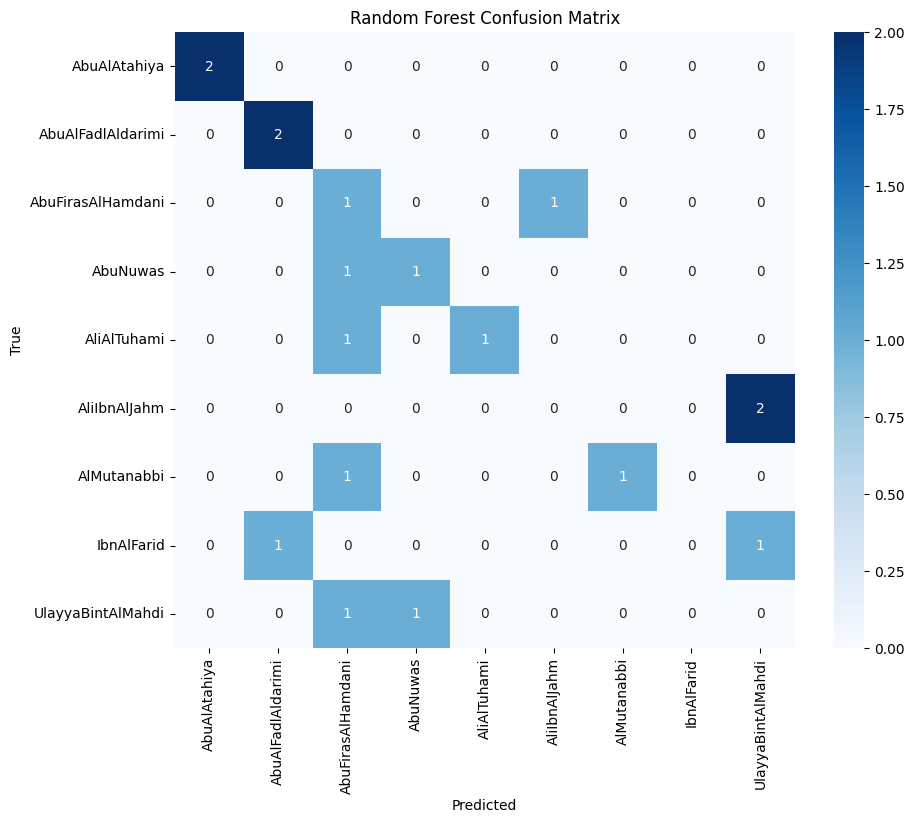

Training SVM...
Classifier: SVM
Accuracy: 0.2777777777777778
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       1.00      0.50      0.67         2
AbuAlFadlAldarimi       1.00      0.50      0.67         2
AbuFirasAlHamdani       0.20      0.50      0.29         2
         AbuNuwas       0.00      0.00      0.00         2
      AlMutanabbi       0.00      0.00      0.00         2
      AliAlTuhami       0.00      0.00      0.00         2
     AliIbnAlJahm       1.00      0.50      0.67         2
       IbnAlFarid       0.00      0.00      0.00         2
UlayyaBintAlMahdi       0.17      0.50      0.25         2

         accuracy                           0.28        18
        macro avg       0.37      0.28      0.28        18
     weighted avg       0.37      0.28      0.28        18




C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


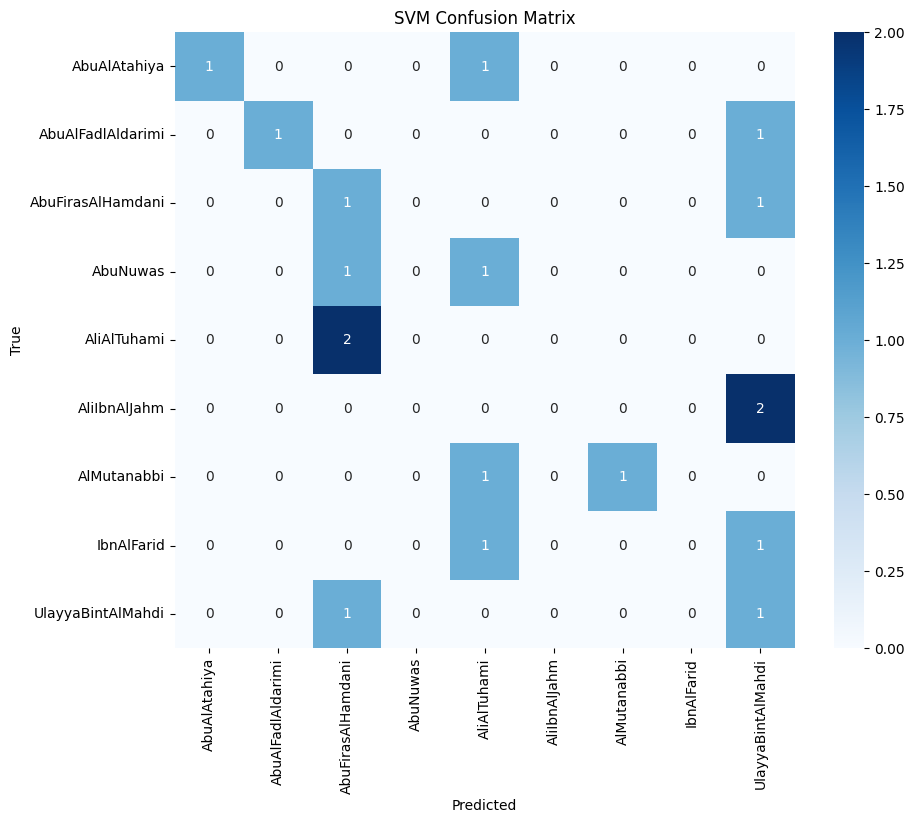

Training K-Nearest Neighbors...
Classifier: K-Nearest Neighbors
Accuracy: 0.3333333333333333
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       0.50      1.00      0.67         2
AbuAlFadlAldarimi       0.25      0.50      0.33         2
AbuFirasAlHamdani       0.33      0.50      0.40         2
         AbuNuwas       0.00      0.00      0.00         2
      AlMutanabbi       0.00      0.00      0.00         2
      AliAlTuhami       0.00      0.00      0.00         2
     AliIbnAlJahm       0.00      0.00      0.00         2
       IbnAlFarid       0.50      0.50      0.50         2
UlayyaBintAlMahdi       0.20      0.50      0.29         2

         accuracy                           0.33        18
        macro avg       0.20      0.33      0.24        18
     weighted avg       0.20      0.33      0.24        18




C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


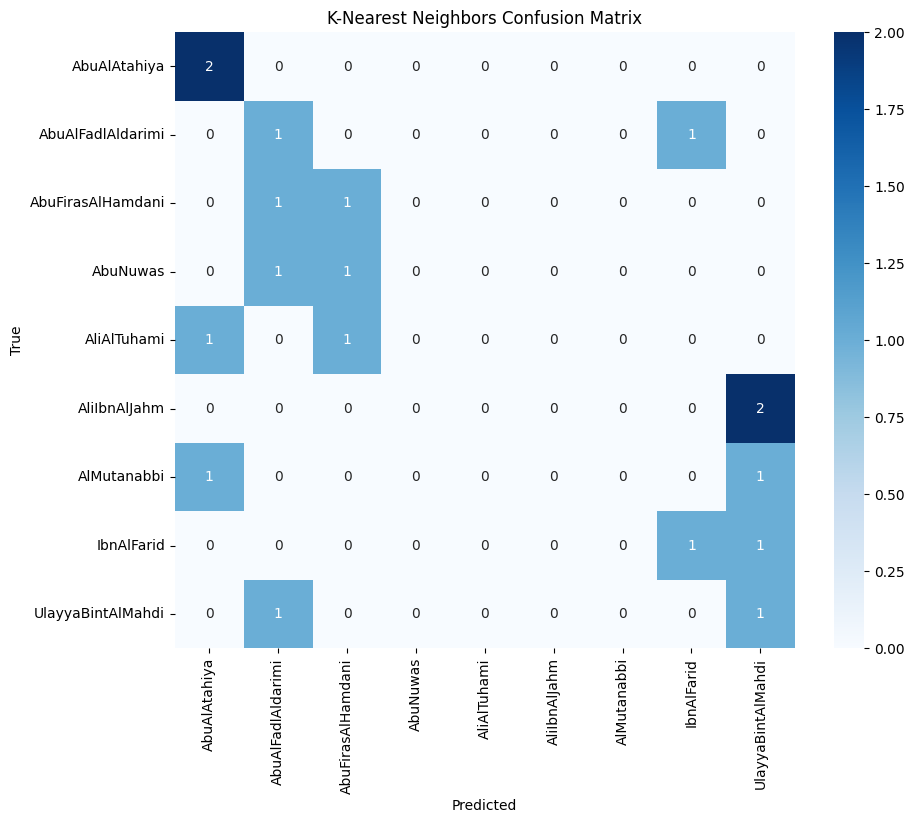

Training MLP...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classi

Classifier: MLP
Accuracy: 0.2777777777777778
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       1.00      0.50      0.67         2
AbuAlFadlAldarimi       0.50      0.50      0.50         2
AbuFirasAlHamdani       0.20      0.50      0.29         2
         AbuNuwas       0.00      0.00      0.00         2
      AlMutanabbi       0.00      0.00      0.00         2
      AliAlTuhami       0.00      0.00      0.00         2
     AliIbnAlJahm       1.00      0.50      0.67         2
       IbnAlFarid       0.00      0.00      0.00         2
UlayyaBintAlMahdi       0.14      0.50      0.22         2

         accuracy                           0.28        18
        macro avg       0.32      0.28      0.26        18
     weighted avg       0.32      0.28      0.26        18




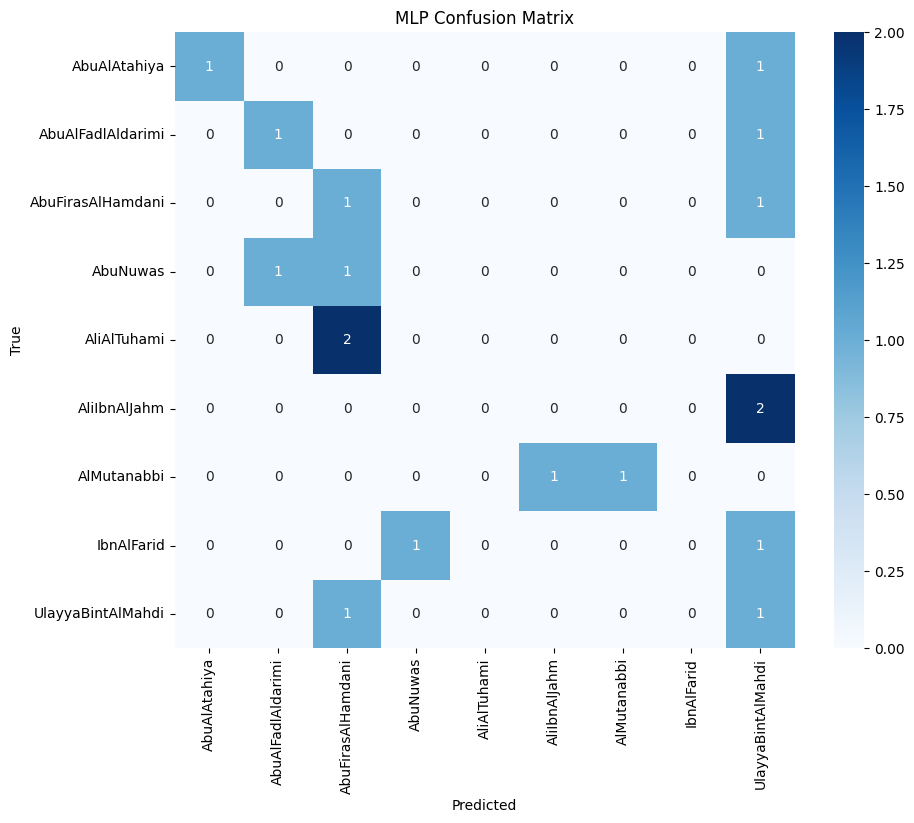

In [75]:
def main():
    dataset_path = 'dataset'  # Specify the path to your dataset
    data, labels, authors, poem_authors = load_data(dataset_path)

    # Split data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of testing samples: {len(test_data)}")

    # Step 1: Extract TF-IDF features
    tf_idf = TFIDFExtractor()
    
    # Debug prints
    print(f"Example of the first training sample: {train_data[0]}")
    print(f"Example of the second training sample: {train_data[1]}")

    # Ensure each sample has at least 4 elements and extract features
    # Handle cases where sample[3] (author label) may be missing
    filtered_train_data = [(sample[0], sample[3]) for sample in train_data if len(sample) > 3]
    tfidf_features = tf_idf.fit_transform(filtered_train_data)

    # Step 2: Extract FastText features
    fast_text_extractor = WordEmbeddingExtractor(vector_size=100)  # Adjust vector_size as needed
    fasttext_features = fast_text_extractor.fit_transform([sample[0] for sample in train_data])

    # Convert test data to feature vectors
    tfidf_features_test = tf_idf.transform([(sample[0], sample[3]) for sample in test_data])
    fasttext_features_test = fast_text_extractor.transform([sample[0] for sample in test_data])

    # Extract meter and rhyme features
    meter_vectors_train = np.array([convert_to_vector(sample[1]) for sample in train_data])
    rhyme_vectors_train = np.array([convert_to_vector(sample[2]) for sample in train_data])
    # pos_features_train = np.array([sample[3] for sample in train_data])  # Assuming POS features are included in data[3]
    # pos_features_test = np.array([sample[3] for sample in test_data])  # Assuming POS features are included in data[3]

    meter_vectors_test = np.array([convert_to_vector(sample[1]) for sample in test_data])
    rhyme_vectors_test = np.array([convert_to_vector(sample[2]) for sample in test_data])

    # Combine all features
    # combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train, pos_features_train)

    # combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test,pos_features_test)

    combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train)

    combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test)

    # Train XGBoost classifier
    # xgb_clf = XGBClassifier()
    # xgb_clf.fit(combined_features_train, train_labels)
    # y_pred = xgb_clf.predict(combined_features_test)


    # # Evaluate performance
    # accuracy = accuracy_score(test_labels, y_pred)
    # report = classification_report(test_labels, y_pred)
    # print(f"XGBoost Classifier Accuracy: {accuracy}")
    # print(f"Classification Report:\n{report}")
    # Train classifiers and evaluate performance
    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "MLP": MLPClassifier()
    }

    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name}...")
        clf.fit(combined_features_train, train_labels)
        y_pred = clf.predict(combined_features_test)

        accuracy = accuracy_score(test_labels, y_pred)
        report = classification_report(test_labels, y_pred)
        print(f"Classifier: {clf_name}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")
        print()

        # Plot confusion matrix
        plot_confusion_matrix(test_labels, y_pred, classes=authors, title=f'{clf_name} Confusion Matrix')

if __name__ == '__main__':
    main()


Number of training samples: 32
Number of testing samples: 8
Example of the first training sample: (['دعت', 'عين', 'صبا', '\n', 'دعء', 'كرر', 'سعه', '\n', 'ولل', 'وحق', 'عذر', 'شيب'], [[0, 1, 1, 4, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2, 1, 3, 0, 5, 1, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'AbuAlFadlAldarimi')
Example of the second training sample: (['داو', 'رفق', 'جرح', 'خرق', '\n', 'وبل', 'لذم', 'لذم', 'حمد', 'وذق', '\n', 'وسع', 'ناس', 'خلق', 'حسن'], [[0, 1, 6, 0, 10, 0, 2, 0, 0, 0, 0, 0, 0, 0

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


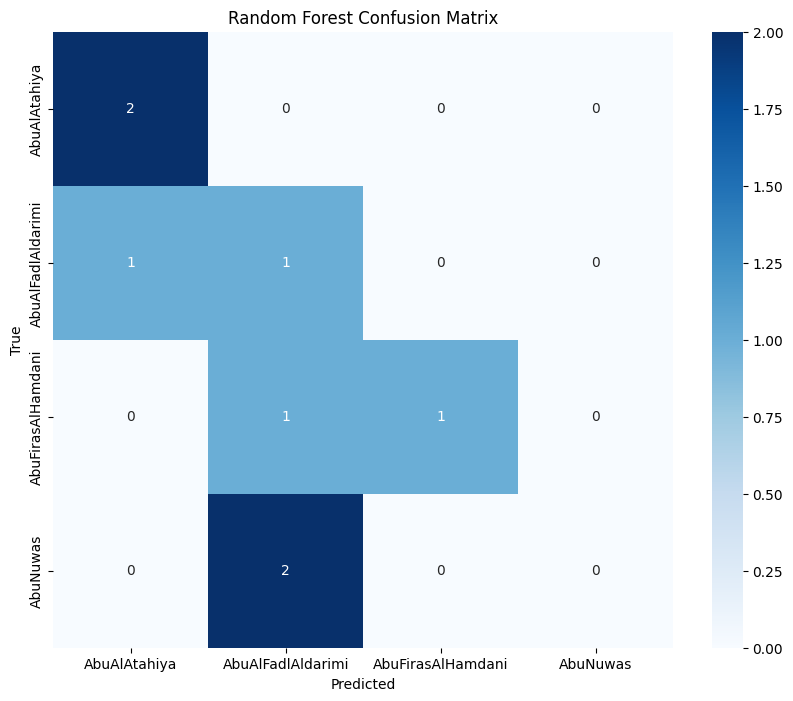

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training SVM...
Classifier: SVM
Accuracy: 0.625
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       0.67      1.00      0.80         2
AbuAlFadlAldarimi       1.00      0.50      0.67         2
AbuFirasAlHamdani       0.50      1.00      0.67         2
         AbuNuwas       0.00      0.00      0.00         2

         accuracy                           0.62         8
        macro avg       0.54      0.62      0.53         8
     weighted avg       0.54      0.62      0.53         8




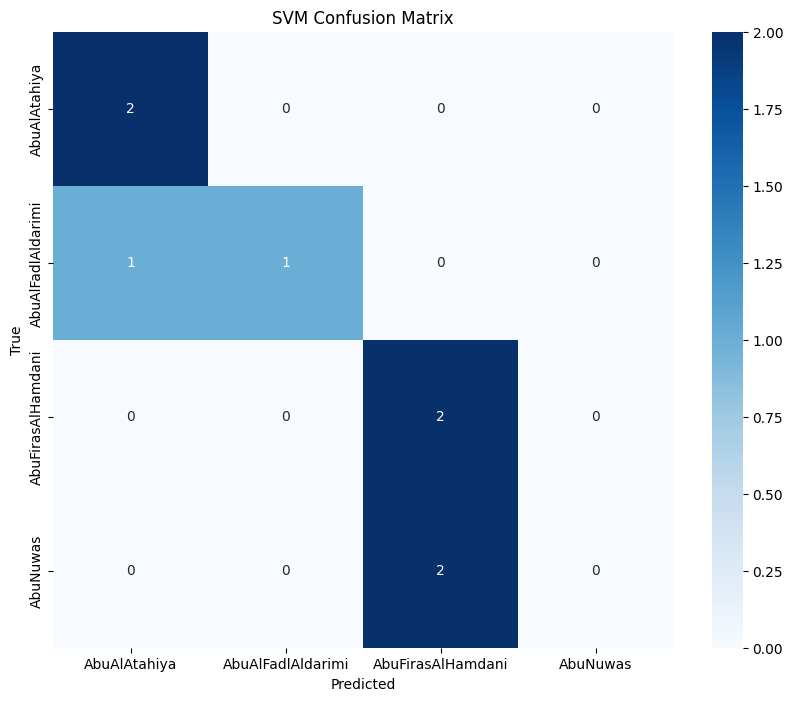

Training K-Nearest Neighbors...
Classifier: K-Nearest Neighbors
Accuracy: 0.625
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       1.00      0.50      0.67         2
AbuAlFadlAldarimi       0.67      1.00      0.80         2
AbuFirasAlHamdani       0.50      0.50      0.50         2
         AbuNuwas       0.50      0.50      0.50         2

         accuracy                           0.62         8
        macro avg       0.67      0.62      0.62         8
     weighted avg       0.67      0.62      0.62         8




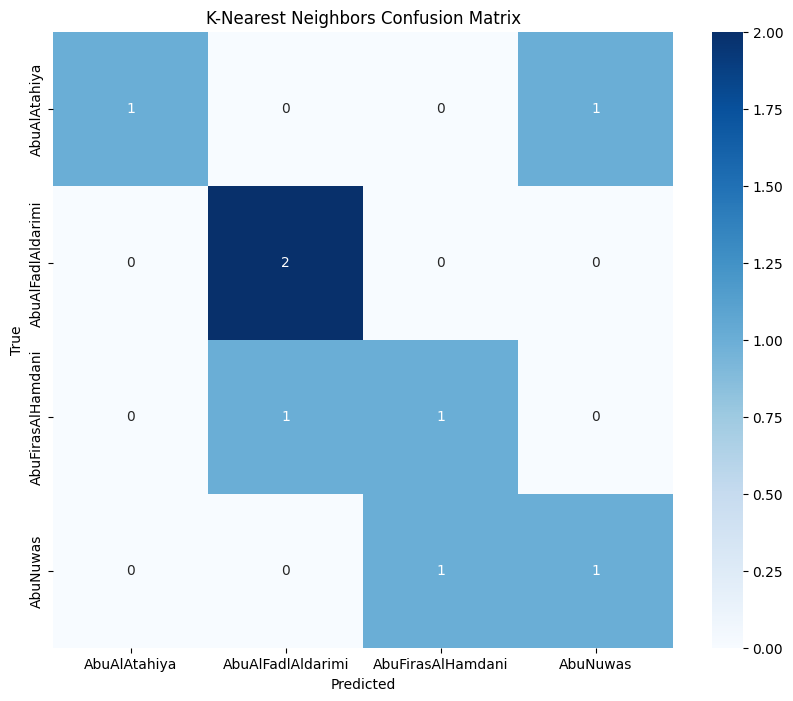

Training MLP...
Classifier: MLP
Accuracy: 0.75
Classification Report:
                   precision    recall  f1-score   support

     AbuAlAtahiya       0.67      1.00      0.80         2
AbuAlFadlAldarimi       1.00      0.50      0.67         2
AbuFirasAlHamdani       0.67      1.00      0.80         2
         AbuNuwas       1.00      0.50      0.67         2

         accuracy                           0.75         8
        macro avg       0.83      0.75      0.73         8
     weighted avg       0.83      0.75      0.73         8




C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


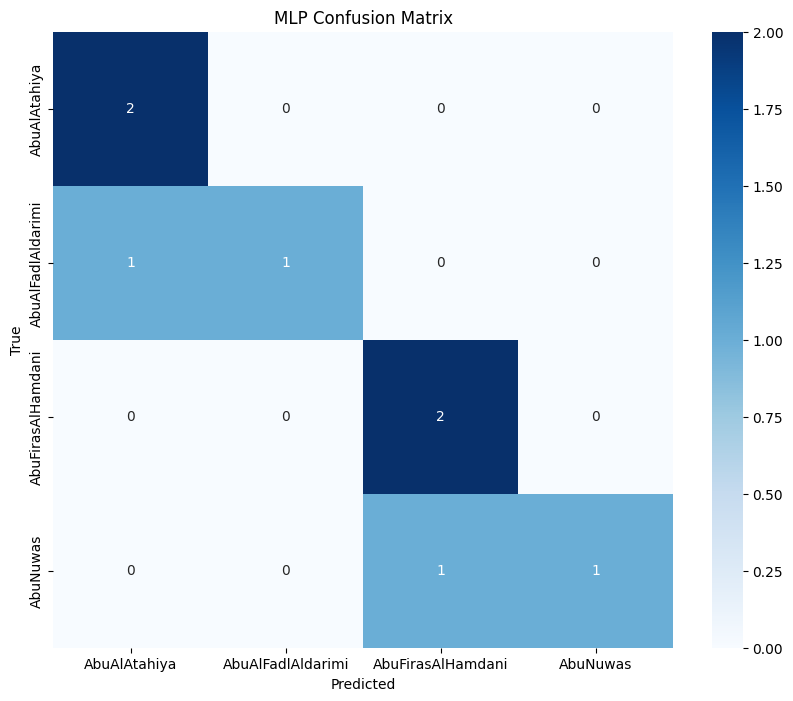

In [76]:
def main():
    dataset_path = 'dataset'  # Specify the path to your dataset
    data, labels, authors, poem_authors = load_data(dataset_path)

    # Split data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

    print(f"Number of training samples: {len(train_data)}")
    print(f"Number of testing samples: {len(test_data)}")

    # Step 1: Extract TF-IDF features
    tf_idf = TFIDFExtractor()
    
    # Debug prints
    print(f"Example of the first training sample: {train_data[0]}")
    print(f"Example of the second training sample: {train_data[1]}")

    # Ensure each sample has at least 4 elements and extract features
    # Handle cases where sample[3] (author label) may be missing
    filtered_train_data = [(sample[0], sample[3]) for sample in train_data if len(sample) > 3]
    tfidf_features = tf_idf.fit_transform(filtered_train_data)

    # Step 2: Extract FastText features
    fast_text_extractor = WordEmbeddingExtractor(vector_size=100)  # Adjust vector_size as needed
    fasttext_features = fast_text_extractor.fit_transform([sample[0] for sample in train_data])

    # Convert test data to feature vectors
    tfidf_features_test = tf_idf.transform([(sample[0], sample[3]) for sample in test_data])
    fasttext_features_test = fast_text_extractor.transform([sample[0] for sample in test_data])

    # Extract meter and rhyme features
    meter_vectors_train = np.array([convert_to_vector(sample[1]) for sample in train_data])
    rhyme_vectors_train = np.array([convert_to_vector(sample[2]) for sample in train_data])
    # pos_features_train = np.array([sample[3] for sample in train_data])  # Assuming POS features are included in data[3]
    # pos_features_test = np.array([sample[3] for sample in test_data])  # Assuming POS features are included in data[3]

    meter_vectors_test = np.array([convert_to_vector(sample[1]) for sample in test_data])
    rhyme_vectors_test = np.array([convert_to_vector(sample[2]) for sample in test_data])

    # Combine all features
    # combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train, pos_features_train)

    # combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test,pos_features_test)

    combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train)

    combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test)

    # Train XGBoost classifier
    # xgb_clf = XGBClassifier()
    # xgb_clf.fit(combined_features_train, train_labels)
    # y_pred = xgb_clf.predict(combined_features_test)


    # # Evaluate performance
    # accuracy = accuracy_score(test_labels, y_pred)
    # report = classification_report(test_labels, y_pred)
    # print(f"XGBoost Classifier Accuracy: {accuracy}")
    # print(f"Classification Report:\n{report}")
    # Train classifiers and evaluate performance
    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "MLP": MLPClassifier()
    }

    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name}...")
        clf.fit(combined_features_train, train_labels)
        y_pred = clf.predict(combined_features_test)

        accuracy = accuracy_score(test_labels, y_pred)
        report = classification_report(test_labels, y_pred)
        print(f"Classifier: {clf_name}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")
        print()

        # Plot confusion matrix
        plot_confusion_matrix(test_labels, y_pred, classes=authors, title=f'{clf_name} Confusion Matrix')

if __name__ == '__main__':
    main()


In [99]:
def filter_data_by_authors(data, labels, authors_subset):
    filtered_data = []
    filtered_labels = []
    for i in range(len(data)):
        if labels[i] in authors_subset:
            filtered_data.append(data[i])
            filtered_labels.append(labels[i])
    return filtered_data, filtered_labels

def main():
    dataset_path = 'dataset'  # Specify the path to your dataset
    data, labels, authors, poem_authors = load_data(dataset_path)

    num_authors = len(set(labels))
    accuracies = {}

    for n in range(num_authors, 1, -1):
        print(f"Evaluating with {n} authors...")
        # Select the first n authors
        authors_subset = list(set(labels))[:n]
        
        # Filter data and labels
        filtered_data, filtered_labels = filter_data_by_authors(data, labels, authors_subset)

        # Split data into training and testing sets
        train_data, test_data, train_labels, test_labels = train_test_split(filtered_data, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels)

        # print(f"Number of training samples: {len(train_data)}")
        # print(f"Number of testing samples: {len(test_data)}")

        # Step 1: Extract TF-IDF features
        tf_idf = TFIDFExtractor()
        
        # # Debug prints
        # print(f"Example of the first training sample: {train_data[0]}")
        # print(f"Example of the second training sample: {train_data[1]}")

        # Ensure each sample has at least 4 elements and extract features
        # Handle cases where sample[3] (author label) may be missing
        filtered_train_data = [(sample[0], sample[3]) for sample in train_data if len(sample) > 3]
        tfidf_features = tf_idf.fit_transform(filtered_train_data)

        # Step 2: Extract FastText features
        fast_text_extractor = WordEmbeddingExtractor(vector_size=100)  # Adjust vector_size as needed
        fasttext_features = fast_text_extractor.fit_transform([sample[0] for sample in train_data])

        # Convert test data to feature vectors
        tfidf_features_test = tf_idf.transform([(sample[0], sample[3]) for sample in test_data])
        fasttext_features_test = fast_text_extractor.transform([sample[0] for sample in test_data])

        # Extract meter and rhyme features
        meter_vectors_train = np.array([convert_to_vector(sample[1]) for sample in train_data])
        rhyme_vectors_train = np.array([convert_to_vector(sample[2]) for sample in train_data])
        # pos_features_train = np.array([sample[3] for sample in train_data])  # Assuming POS features are included in data[3]
        # pos_features_test = np.array([sample[3] for sample in test_data])  # Assuming POS features are included in data[3]

        meter_vectors_test = np.array([convert_to_vector(sample[1]) for sample in test_data])
        rhyme_vectors_test = np.array([convert_to_vector(sample[2]) for sample in test_data])

        # Combine all features
        # combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train, pos_features_train)

        # combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test,pos_features_test)

        combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train)

        combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test)

        # Train classifiers and evaluate performance
        classifiers = {
            "Random Forest": RandomForestClassifier(),
            "SVM": SVC(),
            "K-Nearest Neighbors": KNeighborsClassifier(),
            "MLP": MLPClassifier()
        }

        for clf_name, clf in classifiers.items():
            # print(f"Training {clf_name}...")
            clf.fit(combined_features_train, train_labels)
            y_pred = clf.predict(combined_features_test)

            accuracy = accuracy_score(test_labels, y_pred)
            report = classification_report(test_labels, y_pred)
            # print(f"Classifier: {clf_name}")
            # print(f"Accuracy: {accuracy}")
            # print(f"Classification Report:\n{report}")
            # print()

            # Plot confusion matrix
            # plot_confusion_matrix(test_labels, y_pred, classes=authors_subset, title=f'{clf_name} Confusion Matrix')

            # Store accuracy
            if clf_name not in accuracies:
                accuracies[clf_name] = []
            accuracies[clf_name].append((n, accuracy))

    # Print accuracies
    for clf_name, results in accuracies.items():
        print(f"Accuracies for {clf_name}:")
        for num_authors, acc in results:
            print(f"Number of authors: {num_authors}, Accuracy: {acc}")
        print()

if __name__ == '__main__':
    main()


Evaluating with 9 authors...
TF-IDF Shape: (72, 487)
FastText Shape: (72, 100)
Meter Vectors Shape: (72, 100)
Rhyme Vectors Shape: (72, 100)
TF-IDF Shape: (18, 487)
FastText Shape: (18, 100)
Meter Vectors Shape: (18, 100)
Rhyme Vectors Shape: (18, 100)


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

Evaluating with 8 authors...
TF-IDF Shape: (64, 430)
FastText Shape: (64, 100)
Meter Vectors Shape: (64, 100)
Rhyme Vectors Shape: (64, 100)
TF-IDF Shape: (16, 430)
FastText Shape: (16, 100)
Meter Vectors Shape: (16, 100)
Rhyme Vectors Shape: (16, 100)


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

Evaluating with 7 authors...
TF-IDF Shape: (56, 368)
FastText Shape: (56, 100)
Meter Vectors Shape: (56, 100)
Rhyme Vectors Shape: (56, 100)
TF-IDF Shape: (14, 368)
FastText Shape: (14, 100)
Meter Vectors Shape: (14, 100)
Rhyme Vectors Shape: (14, 100)


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

Evaluating with 6 authors...
TF-IDF Shape: (48, 313)
FastText Shape: (48, 100)
Meter Vectors Shape: (48, 100)
Rhyme Vectors Shape: (48, 100)
TF-IDF Shape: (12, 313)
FastText Shape: (12, 100)
Meter Vectors Shape: (12, 100)
Rhyme Vectors Shape: (12, 100)


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

Evaluating with 5 authors...
TF-IDF Shape: (40, 272)
FastText Shape: (40, 100)
Meter Vectors Shape: (40, 100)
Rhyme Vectors Shape: (40, 100)
TF-IDF Shape: (10, 272)
FastText Shape: (10, 100)
Meter Vectors Shape: (10, 100)
Rhyme Vectors Shape: (10, 100)


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

Evaluating with 4 authors...
TF-IDF Shape: (32, 220)
FastText Shape: (32, 100)
Meter Vectors Shape: (32, 100)
Rhyme Vectors Shape: (32, 100)
TF-IDF Shape: (8, 220)
FastText Shape: (8, 100)
Meter Vectors Shape: (8, 100)
Rhyme Vectors Shape: (8, 100)


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

Evaluating with 3 authors...
TF-IDF Shape: (24, 163)
FastText Shape: (24, 100)
Meter Vectors Shape: (24, 100)
Rhyme Vectors Shape: (24, 100)
TF-IDF Shape: (6, 163)
FastText Shape: (6, 100)
Meter Vectors Shape: (6, 100)
Rhyme Vectors Shape: (6, 100)


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

Evaluating with 2 authors...
TF-IDF Shape: (16, 112)
FastText Shape: (16, 100)
Meter Vectors Shape: (16, 100)
Rhyme Vectors Shape: (16, 100)
TF-IDF Shape: (4, 112)
FastText Shape: (4, 100)
Meter Vectors Shape: (4, 100)
Rhyme Vectors Shape: (4, 100)


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracies for Random Forest:
Number of authors: 9, Accuracy: 0.2777777777777778
Number of authors: 8, Accuracy: 0.375
Number of authors: 7, Accuracy: 0.2857142857142857
Number of authors: 6, Accuracy: 0.25
Number of authors: 5, Accuracy: 0.5
Number of authors: 4, Accuracy: 0.5
Number of authors: 3, Accuracy: 0.3333333333333333
Number of authors: 2, Accuracy: 0.75

Accuracies for SVM:
Number of authors: 9, Accuracy: 0.2777777777777778
Number of authors: 8, Accuracy: 0.3125
Number of authors: 7, Accuracy: 0.35714285714285715
Number of authors: 6, Accuracy: 0.25
Number of authors: 5, Accuracy: 0.4
Number of authors: 4, Accuracy: 0.25
Number of authors: 3, Accuracy: 0.3333333333333333
Number of authors: 2, Accuracy: 0.5

Accuracies for K-Nearest Neighbors:
Number of authors: 9, Accuracy: 0.3333333333333333
Number of authors: 8, Accuracy: 0.125
Number of authors: 7, Accuracy: 0.35714285714285715
Number of authors: 6, Accuracy: 0.25
Number of authors: 5, Accuracy: 0.3
Number of authors: 4, 

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating with 9 authors...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating with 8 authors...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating with 7 authors...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating with 6 authors...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating with 5 authors...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating with 4 authors...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating with 3 authors...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating with 2 authors...


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Average accuracies for Random Forest:
Number of authors: 9, Average Accuracy: 0.2222
Number of authors: 8, Average Accuracy: 0.3750
Number of authors: 7, Average Accuracy: 0.2857
Number of authors: 6, Average Accuracy: 0.4137
Number of authors: 5, Average Accuracy: 0.4310
Number of authors: 4, Average Accuracy: 0.4990
Number of authors: 3, Average Accuracy: 0.5437
Number of authors: 2, Average Accuracy: 0.6875
Average accuracies for SVM:
Number of authors: 9, Average Accuracy: 0.2778
Number of authors: 8, Average Accuracy: 0.3125
Number of authors: 7, Average Accuracy: 0.3571
Number of authors: 6, Average Accuracy: 0.3998
Number of authors: 5, Average Accuracy: 0.3865
Number of authors: 4, Average Accuracy: 0.4306
Number of authors: 3, Average Accuracy: 0.5198
Number of authors: 2, Average Accuracy: 0.6181
Average accuracies for K-Nearest Neighbors:
Number of authors: 9, Average Accuracy: 0.3333
Number of authors: 8, Average Accuracy: 0.1250
Number of authors: 7, Average Accuracy: 0.35

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


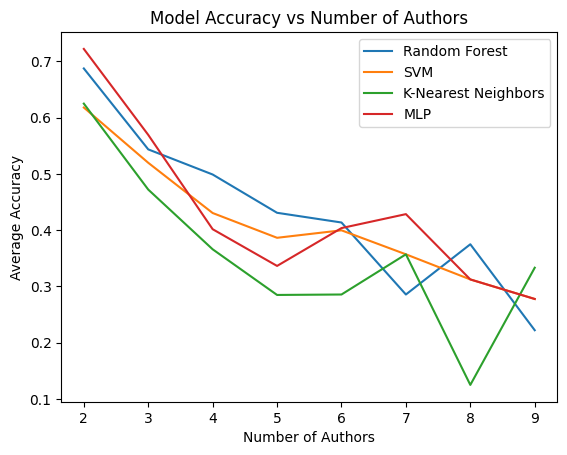

In [104]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

def filter_data_by_authors(data, labels, authors_subset):
    filtered_data = []
    filtered_labels = []
    for i in range(len(data)):
        if labels[i] in authors_subset:
            filtered_data.append(data[i])
            filtered_labels.append(labels[i])
    return filtered_data, filtered_labels

def main():
    dataset_path = 'dataset'  # Specify the path to your dataset
    data, labels, authors, poem_authors = load_data(dataset_path)

    num_authors = len(set(labels))
    accuracies = {clf_name: [] for clf_name in ["Random Forest", "SVM", "K-Nearest Neighbors", "MLP"]}
    
    for n in range(num_authors, 1, -1):
        print(f"Evaluating with {n} authors...")
        if n > 6:
            authors_combinations = [tuple(list(set(labels))[:n])]
        else:
            authors_combinations = list(itertools.combinations(set(labels), n))
        
        combination_accuracies = {clf_name: [] for clf_name in ["Random Forest", "SVM", "K-Nearest Neighbors", "MLP"]}

        for authors_subset in authors_combinations:
            # Filter data and labels
            filtered_data, filtered_labels = filter_data_by_authors(data, labels, authors_subset)

            # Split data into training and testing sets
            train_data, test_data, train_labels, test_labels = train_test_split(filtered_data, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels)

            # Step 1: Extract TF-IDF features
            tf_idf = TFIDFExtractor()
            filtered_train_data = [(sample[0], sample[3]) for sample in train_data if len(sample) > 3]
            tfidf_features = tf_idf.fit_transform(filtered_train_data)

            # Step 2: Extract FastText features
            fast_text_extractor = WordEmbeddingExtractor(vector_size=100)  # Adjust vector_size as needed
            fasttext_features = fast_text_extractor.fit_transform([sample[0] for sample in train_data])

            # Convert test data to feature vectors
            tfidf_features_test = tf_idf.transform([(sample[0], sample[3]) for sample in test_data])
            fasttext_features_test = fast_text_extractor.transform([sample[0] for sample in test_data])

            # Extract meter and rhyme features
            meter_vectors_train = np.array([convert_to_vector(sample[1]) for sample in train_data])
            rhyme_vectors_train = np.array([convert_to_vector(sample[2]) for sample in train_data])

            meter_vectors_test = np.array([convert_to_vector(sample[1]) for sample in test_data])
            rhyme_vectors_test = np.array([convert_to_vector(sample[2]) for sample in test_data])

            # Combine all features
            combined_features_train = combine_features(tfidf_features.toarray(), fasttext_features, meter_vectors_train, rhyme_vectors_train)
            combined_features_test = combine_features(tfidf_features_test.toarray(), fasttext_features_test, meter_vectors_test, rhyme_vectors_test)

            # Train classifiers and evaluate performance
            classifiers = {
                "Random Forest": RandomForestClassifier(),
                "SVM": SVC(),
                "K-Nearest Neighbors": KNeighborsClassifier(),
                "MLP": MLPClassifier()
            }

            for clf_name, clf in classifiers.items():
                clf.fit(combined_features_train, train_labels)
                y_pred = clf.predict(combined_features_test)

                accuracy = accuracy_score(test_labels, y_pred)
                combination_accuracies[clf_name].append(accuracy)

        # Calculate average accuracy for each classifier
        for clf_name in accuracies.keys():
            avg_accuracy = np.mean(combination_accuracies[clf_name])
            accuracies[clf_name].append((n, avg_accuracy))

    # Print and plot accuracies
    for clf_name, results in accuracies.items():
        print(f"Average accuracies for {clf_name}:")
        num_authors_list, avg_accuracies = zip(*results)
        for num_authors, avg_acc in results:
            print(f"Number of authors: {num_authors}, Average Accuracy: {avg_acc:.4f}")
        
        plt.plot(num_authors_list, avg_accuracies, label=clf_name)

    plt.xlabel('Number of Authors')
    plt.ylabel('Average Accuracy')
    plt.title('Model Accuracy vs Number of Authors')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()
